In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [3]:
wage = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [4]:
wage.shape

(284, 1)

In [5]:
wage.columns = ["salary"]

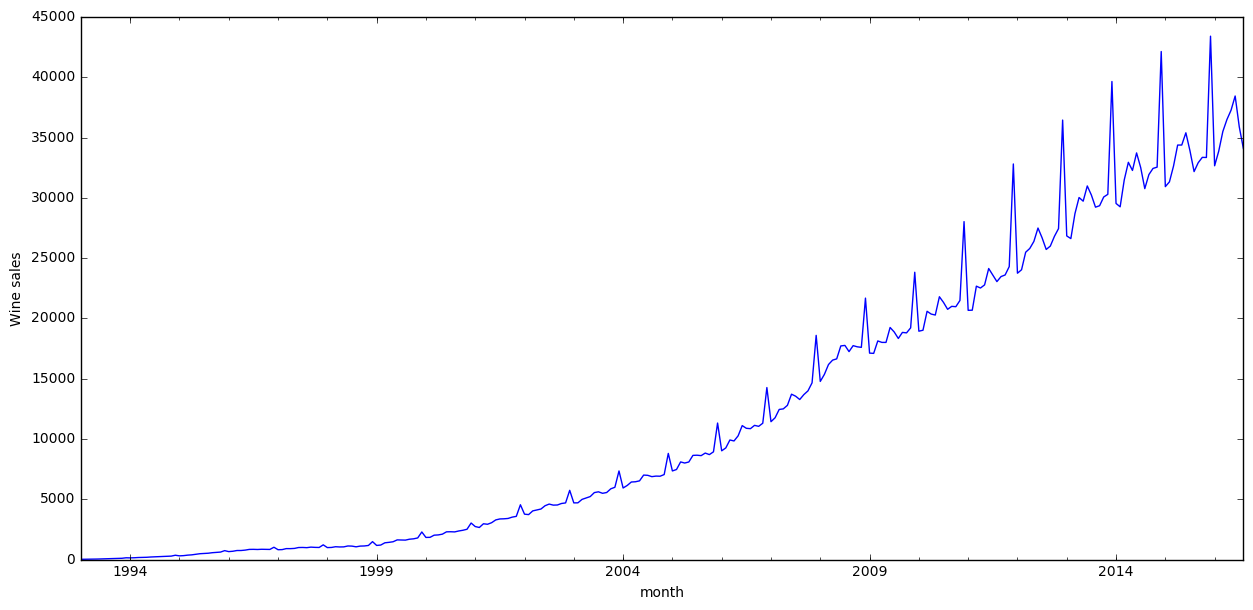

In [6]:
plt.figure(figsize(15,7))
wage.salary.plot()
plt.ylabel('Wine sales')
pylab.show()

In [7]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(wage.salary)[1])

Dickey-Fuller test: p=0.991850


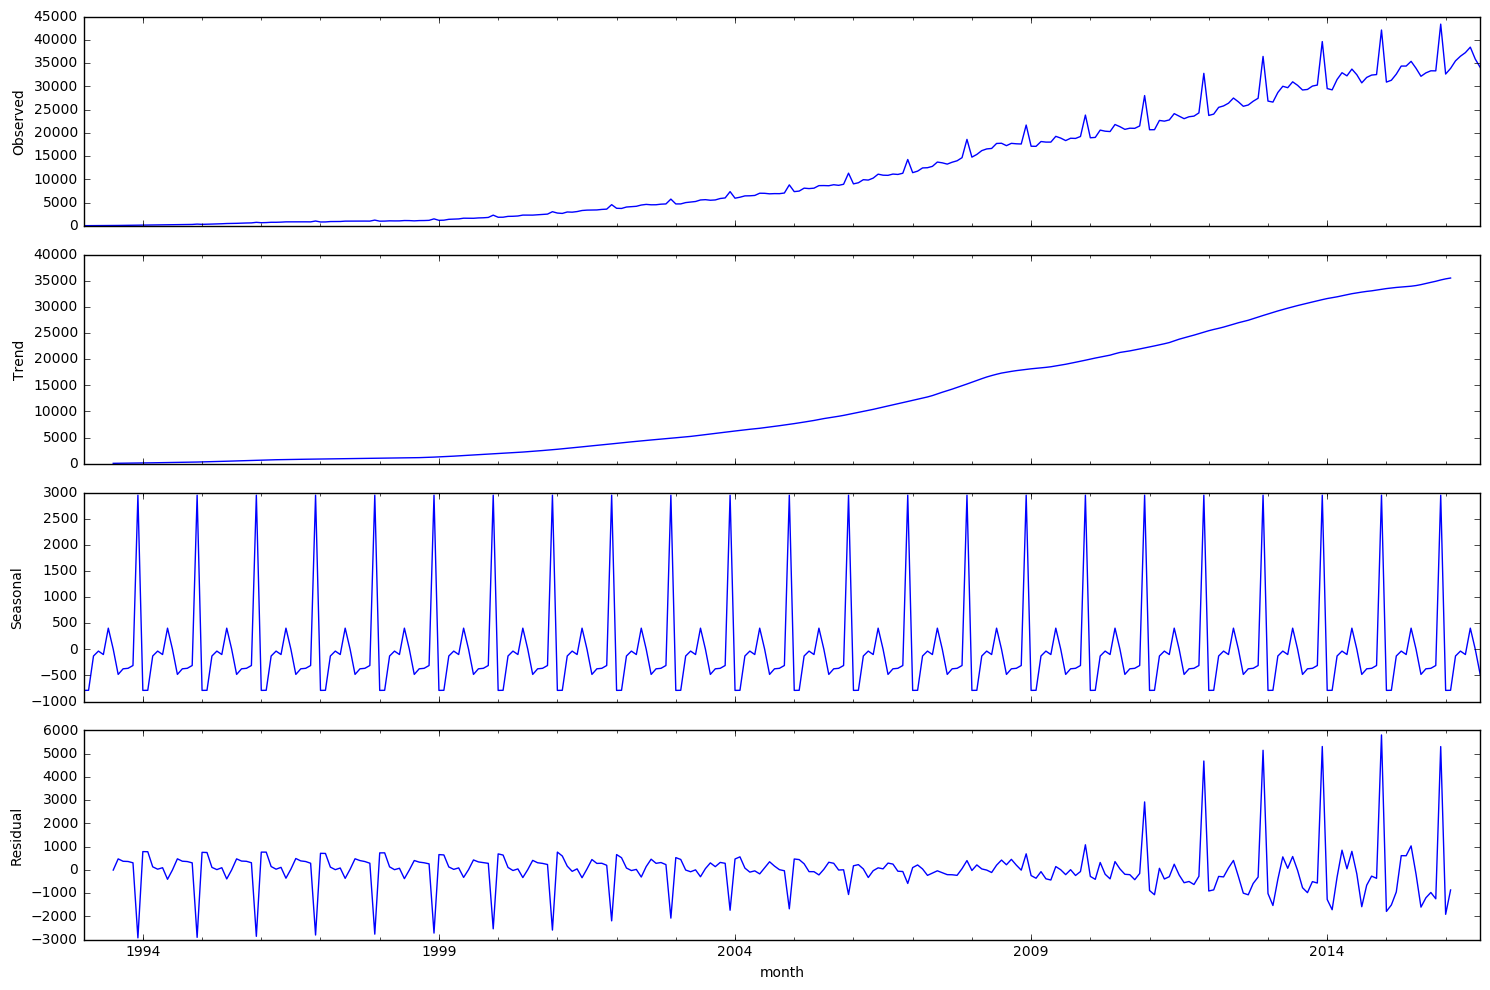

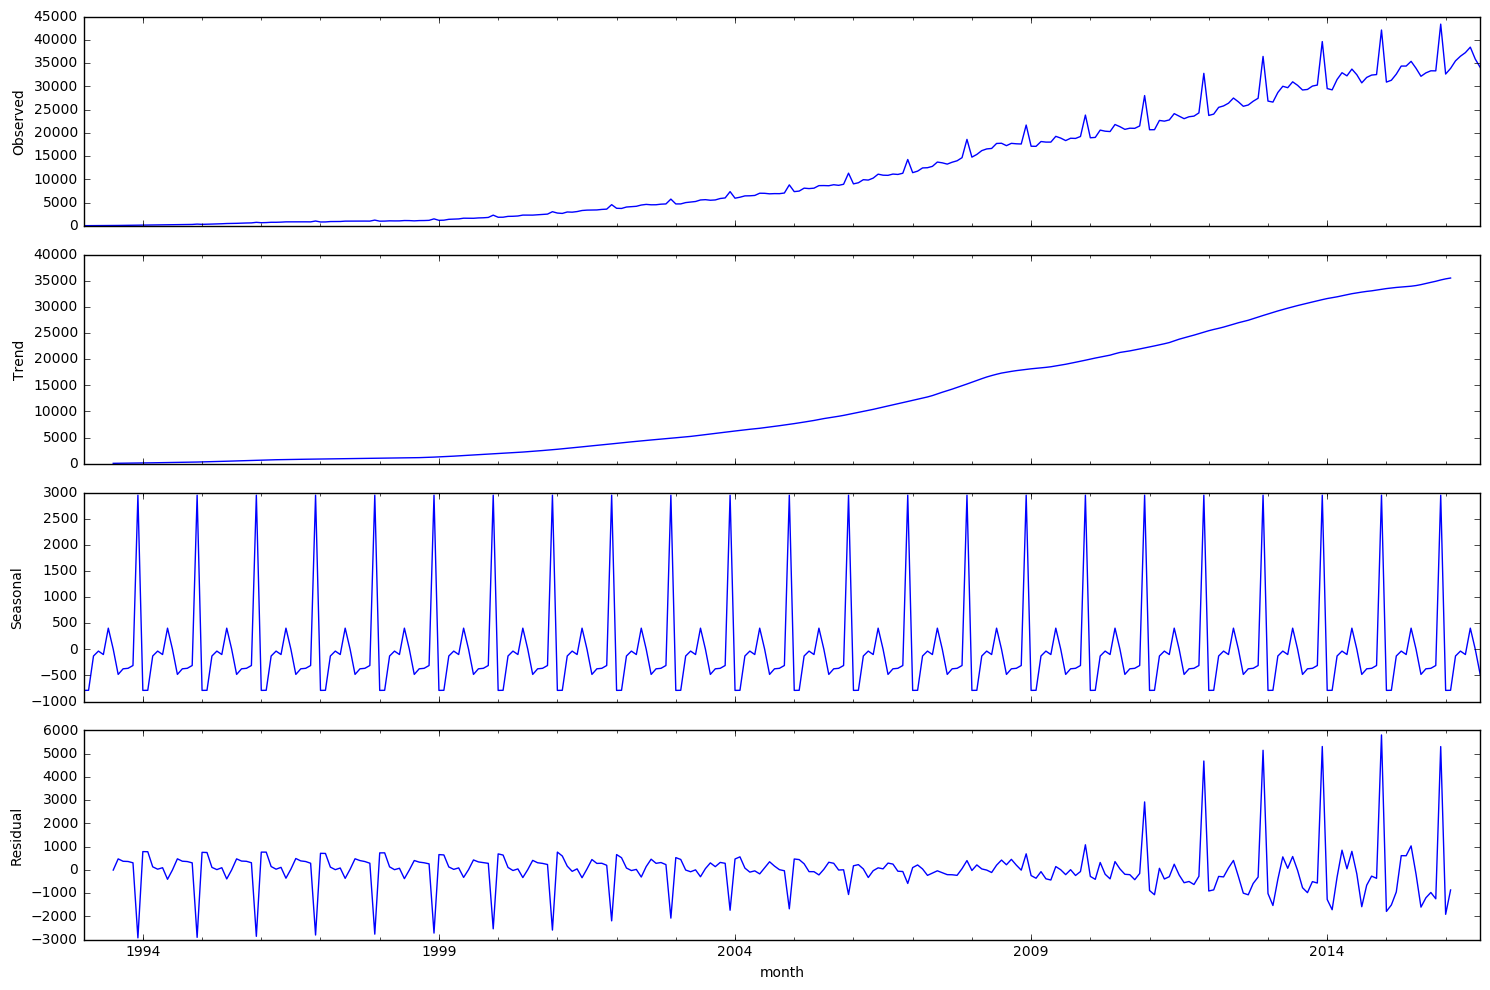

In [8]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.salary).plot()

Optimal param for Box-Cox transformation: 0.263202
Dickey-Fuller test: p=0.991850


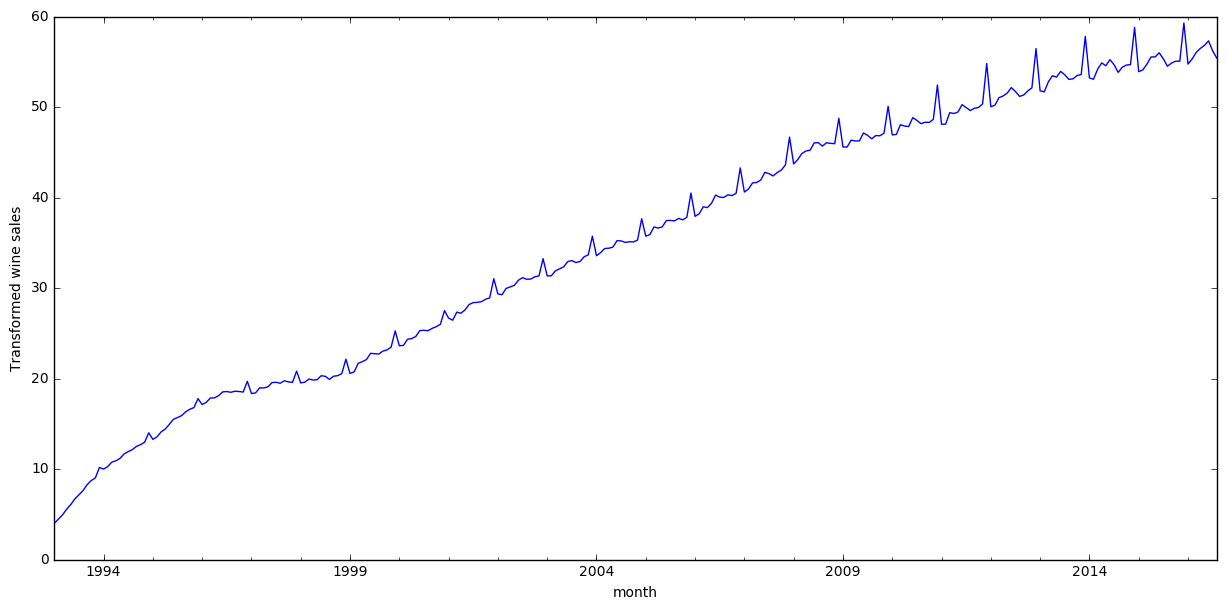

In [9]:
wage['salaries_box'], lmbda = stats.boxcox(wage.salary)
plt.figure(figsize(15,7))
wage.salaries_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Optimal param for Box-Cox transformation: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(wage.salary)[1])

In [10]:
wage['salary_box_diff'] = wage.salaries_box - wage.salaries_box.shift(12)

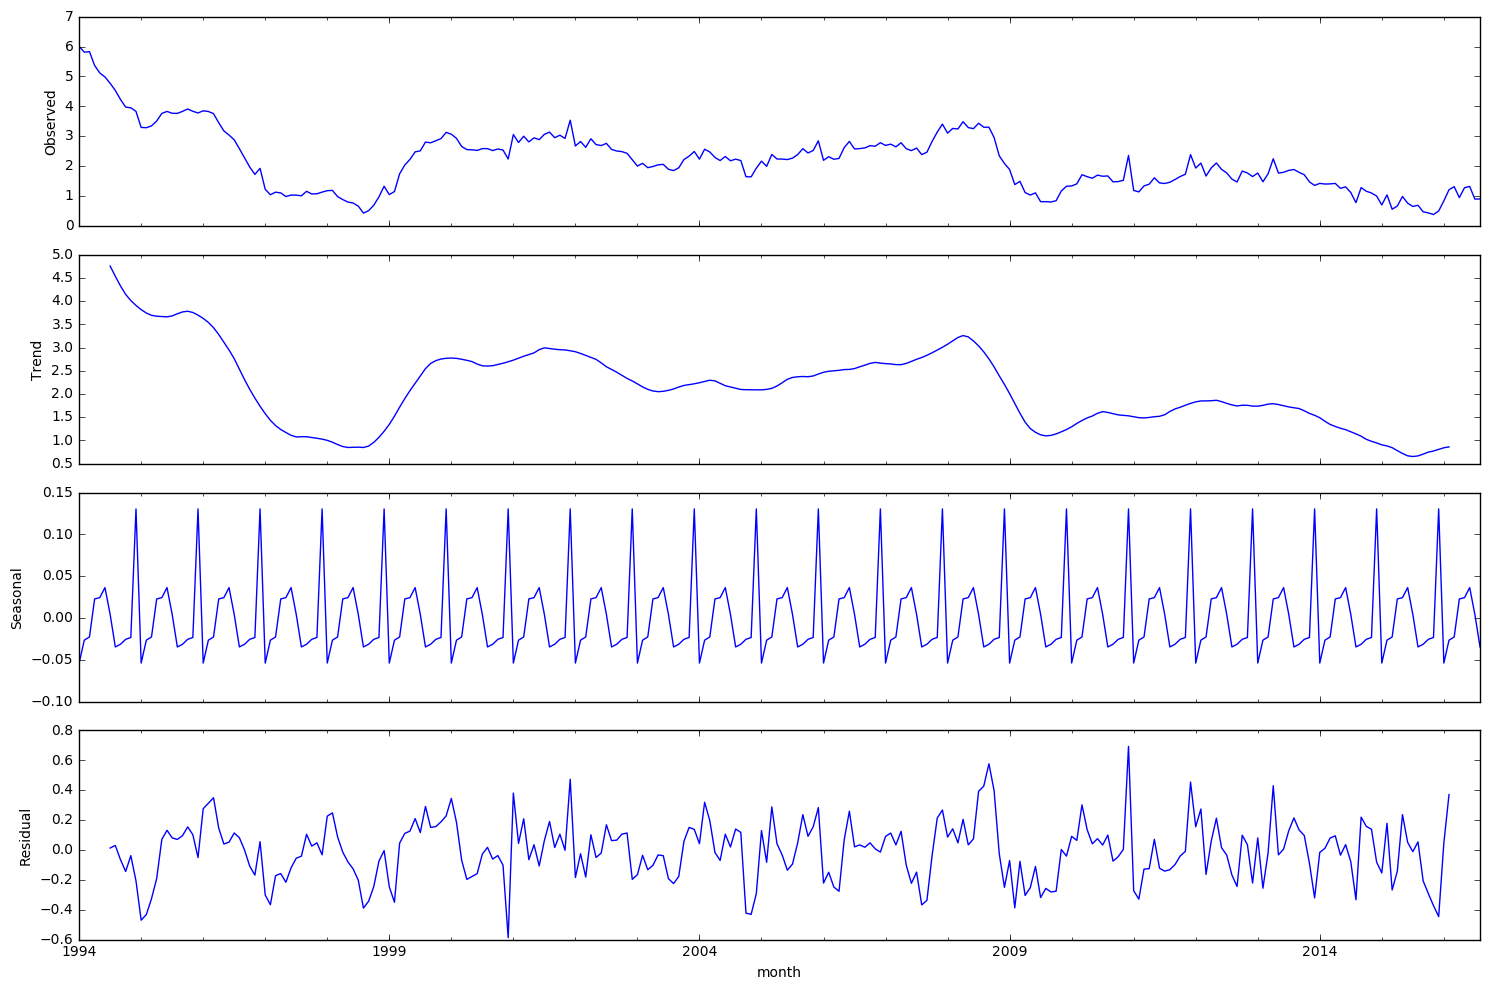

In [11]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.salary_box_diff[12:]).plot()
plt.show()

Dickey-Fuller test: p=0.000000


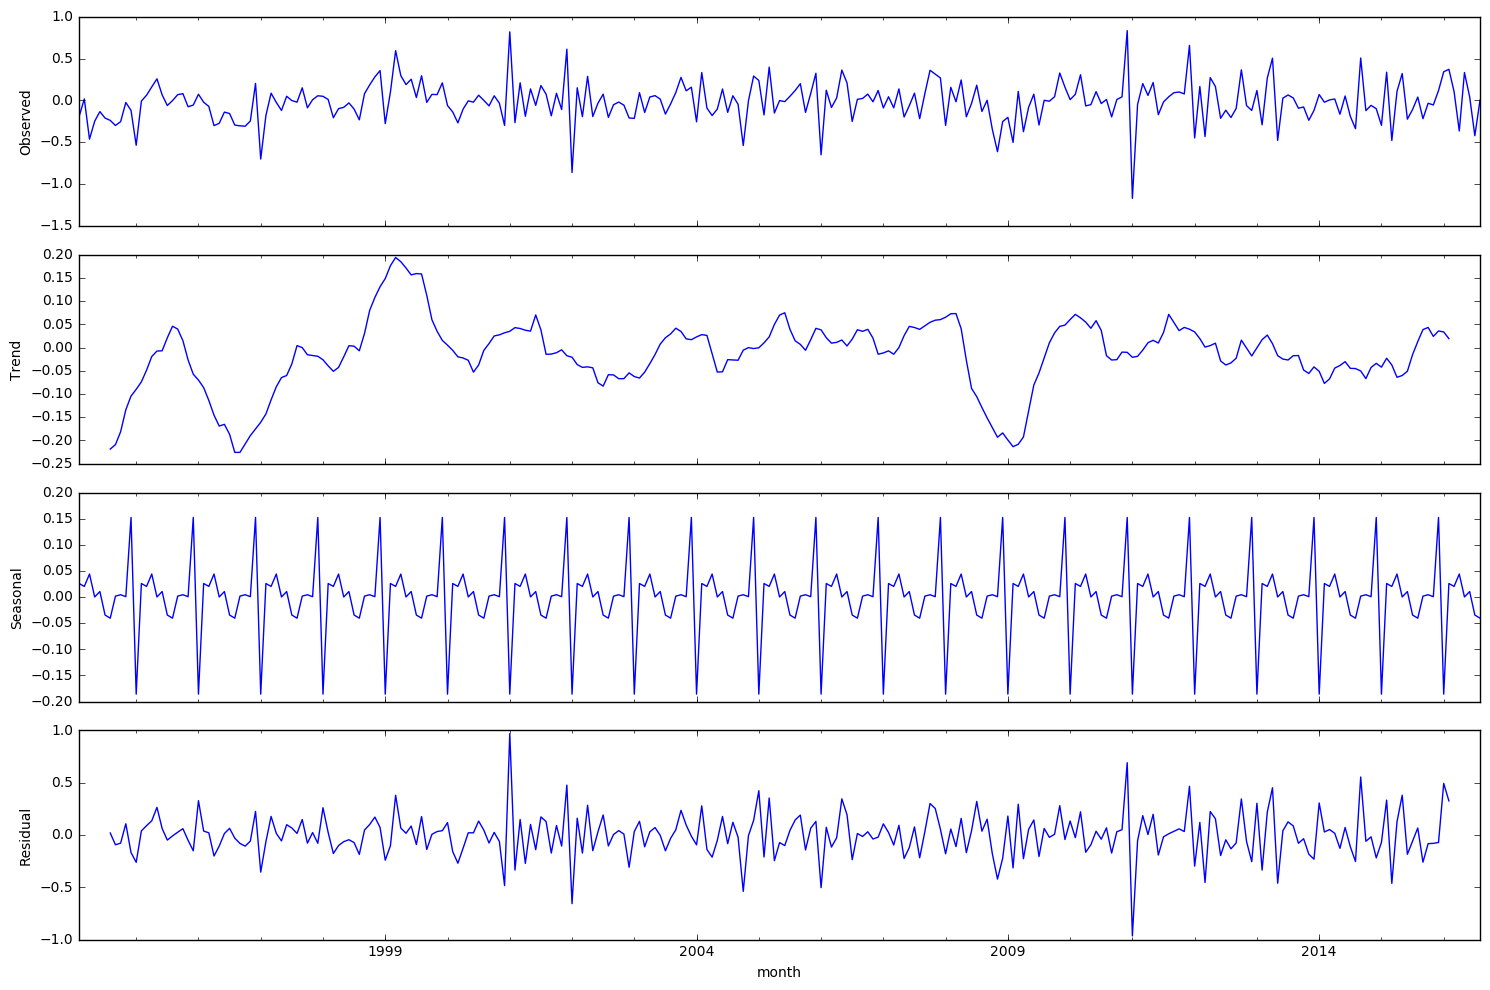

In [12]:
wage['salary_box_diff2'] = wage.salary_box_diff - wage.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.salary_box_diff2[13:]).plot()   
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(wage.salary_box_diff2[13:])[1])

Dickey-Fuller test: p=0.000000


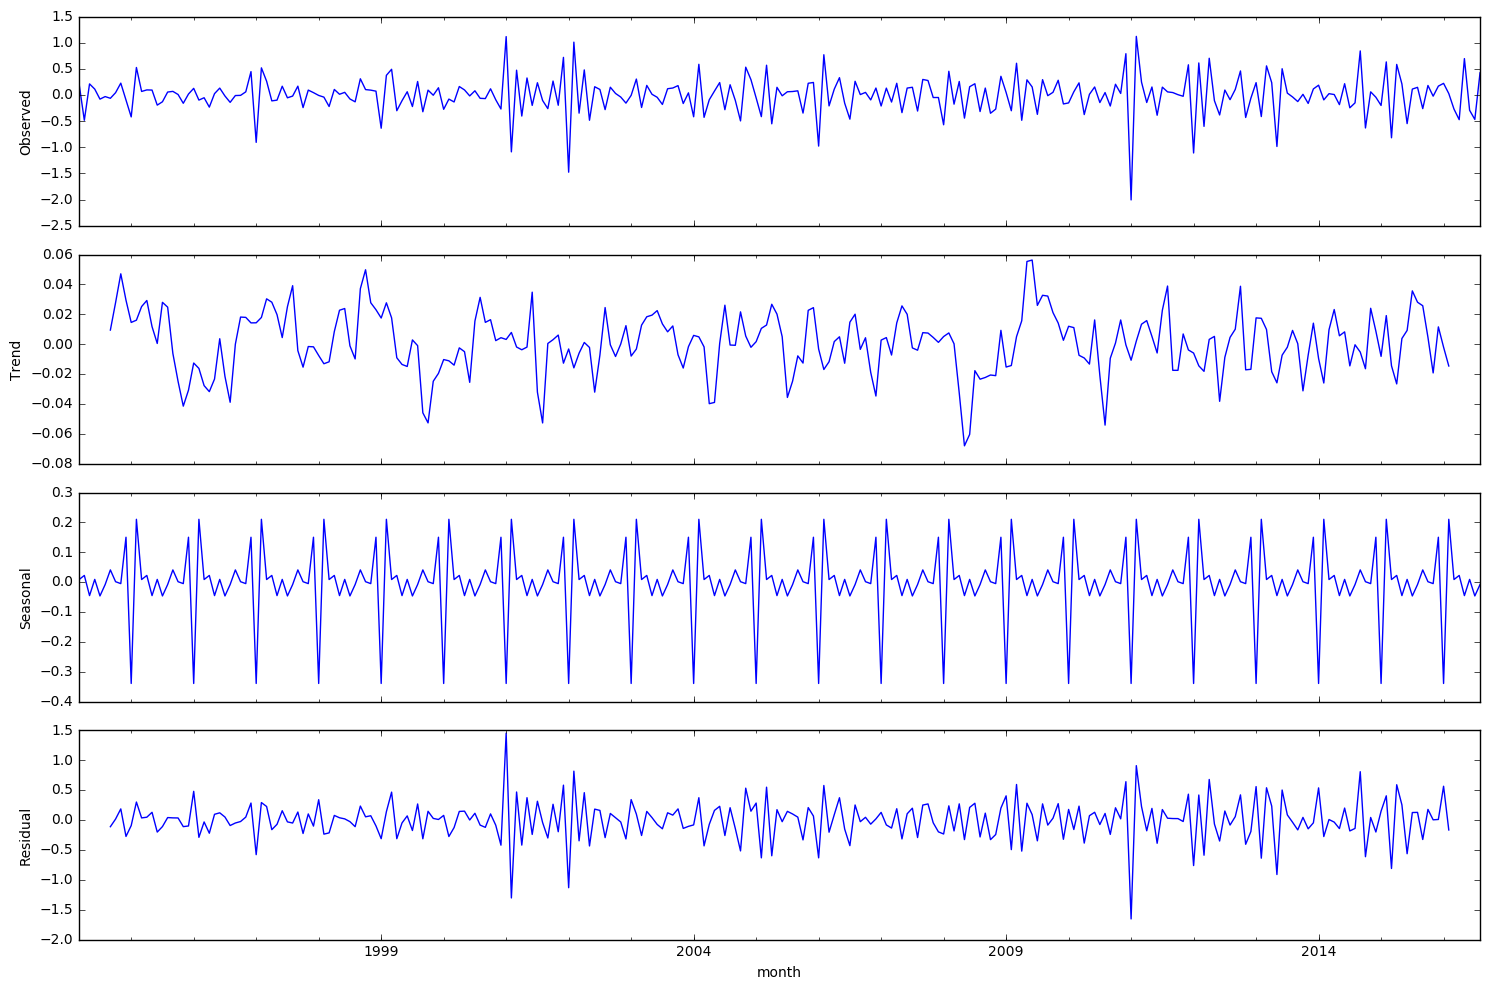

In [13]:
wage['salary_box_diff3'] = wage.salary_box_diff2 - wage.salary_box_diff2.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.salary_box_diff3[14:]).plot()   
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(wage.salary_box_diff3[14:])[1])

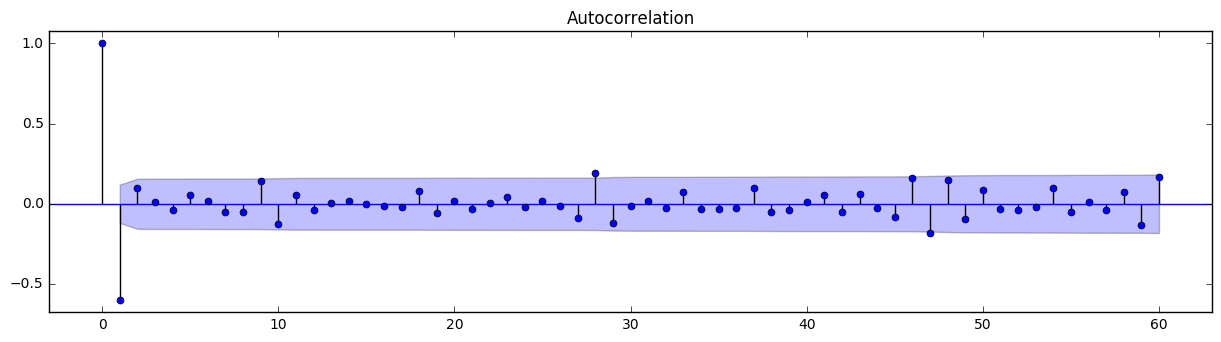

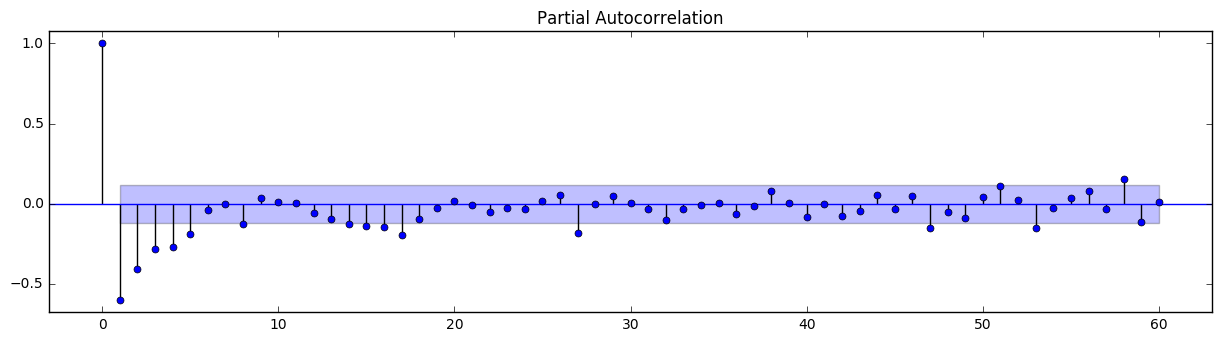

In [14]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.salary_box_diff3[14:].values.squeeze(), lags=60, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.salary_box_diff3[14:].values.squeeze(), lags=60, ax=ax)
pylab.show()

In [23]:
#Q=2, q=1, P=2, p=5
ps = range(0, 4)
d=1
qs = range(0, 2)
Ps = range(0, 3)
D=1
Qs = range(0, 3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [24]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(wage.salaries_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
   
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
   
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 0, 2))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 1, 1, 2))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 2, 1))
('wrong parameters:', (2, 1, 2, 2))
Wall time: 2min 15s


In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
61  (3, 1, 2, 2) -7.749248
88  (5, 0, 2, 2) -7.606462
92  (5, 1, 1, 0) -5.260134
93  (5, 1, 1, 1) -5.074467
56  (3, 1, 1, 0) -4.995860


In [18]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       salaries_box   No. Observations:                  284
Model:             SARIMAX(3, 1, 1)x(2, 1, 2, 12)   Log Likelihood                  12.875
Date:                            Fri, 24 Feb 2017   AIC                             -7.749
Time:                                    18:47:04   BIC                             25.092
Sample:                                01-01-1993   HQIC                             5.417
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4985      0.199      2.510      0.012       0.109       0.888
ar.L2          0.1533      0.080   

Student's test: p=0.815649
Dickey-Fuller test: p=0.000000


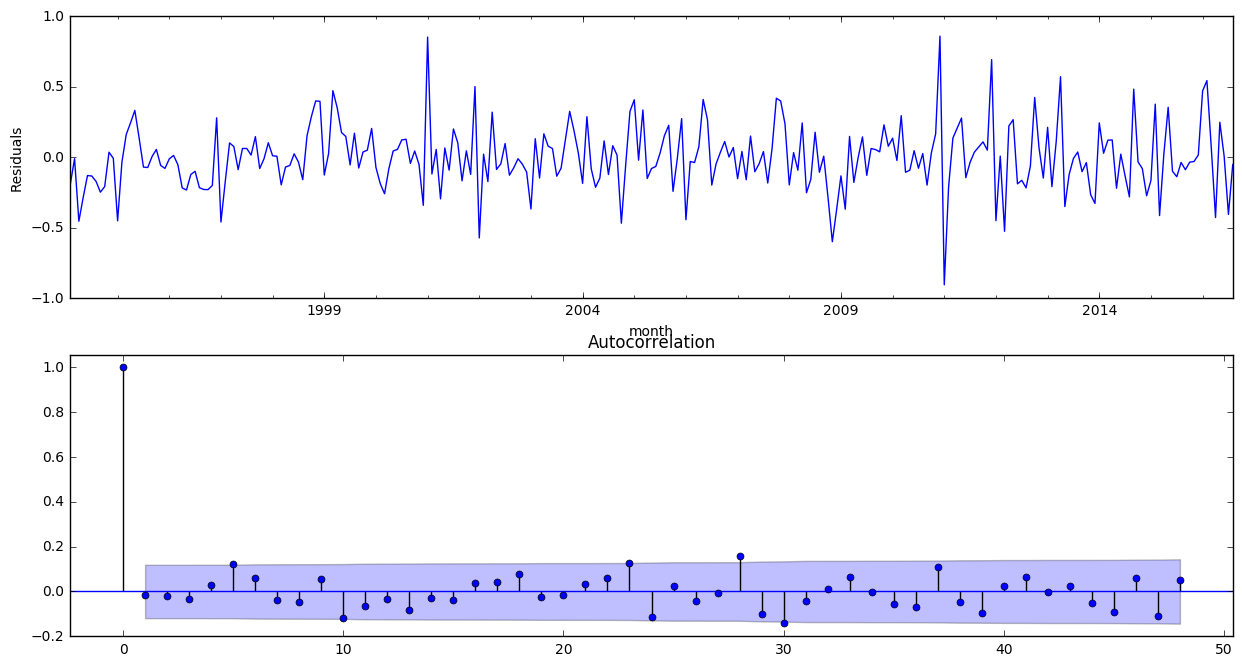

In [19]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

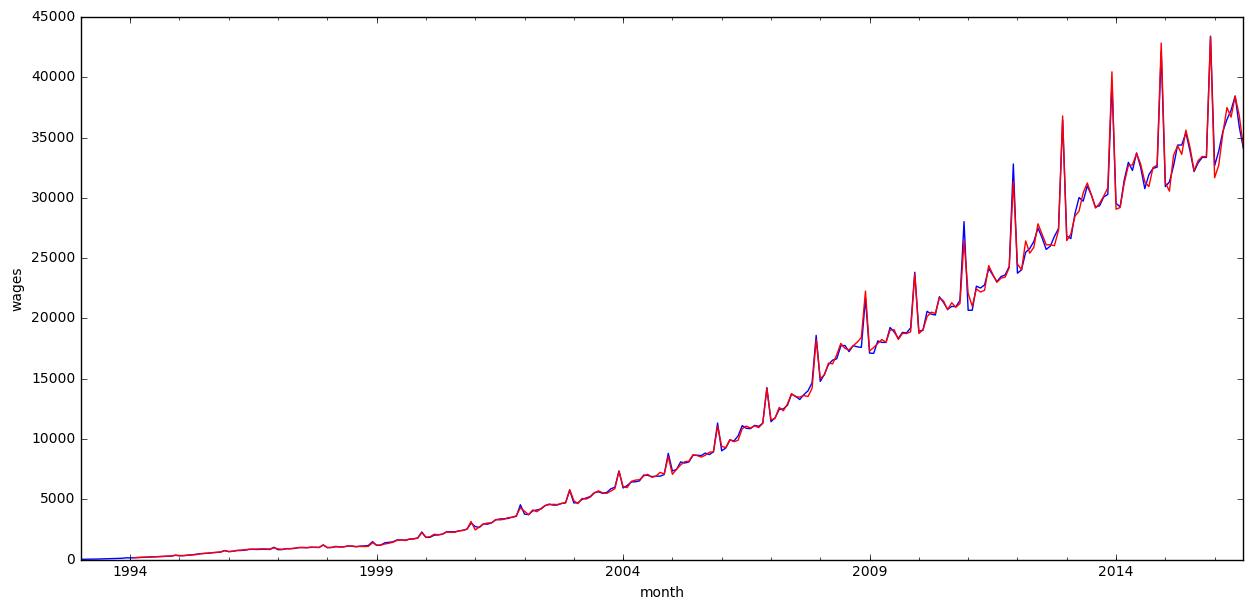

In [20]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.salary.plot()
wage.model[13:].plot(color='r')
plt.ylabel('wages')
pylab.show()

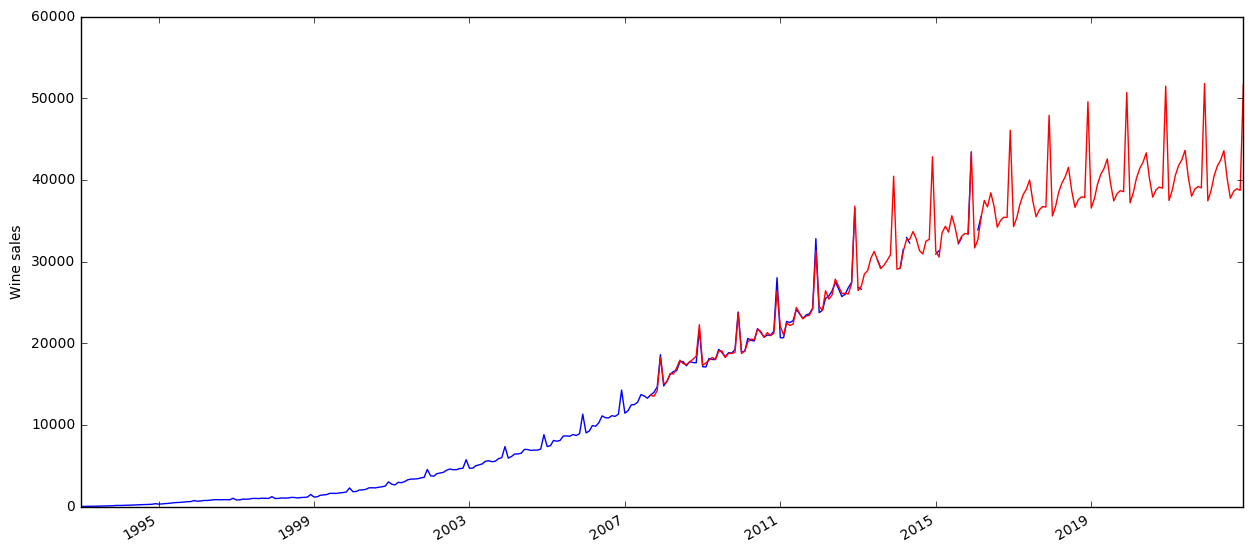

In [21]:
wine2 = wage[['salary']]
date_list = [datetime.datetime.strptime("2013-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,120)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(best_model.predict(start=176, end=500), lmbda)

plt.figure(figsize(15,7))
wine2.salary.plot()
wine2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

In [22]:
wine2.shape

(404, 2)